# TPUs in Colab&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a>
In this example, we'll work through training a model to classify images of
flowers on Google's lightning-fast Cloud TPUs. Our model will take as input a photo of a flower and return whether it is a daisy, dandelion, rose, sunflower, or tulip.

We use the Keras framework, new to TPUs in TF 2.1.0. Adapted from [this notebook](https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/07_Keras_Flowers_TPU_xception_fine_tuned_best.ipynb) by [Martin Gorner](https://twitter.com/martin_gorner).

#### License

Copyright 2019-2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose.


## Enabling and testing the TPU

First, you'll need to enable TPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select TPU from the Hardware Accelerator drop-down

Next, we'll check that we can connect to the TPU:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.3.0
Running on TPU  ['10.109.12.50:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.109.12.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.109.12.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import random
from copy import deepcopy
import _pickle as pickle
import gc
from multiprocess import Pool
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import KBinsDiscretizer
import tensorflow.keras.utils as np_utils
from tensorflow.keras.optimizers import Adam, SGD
def save(file,name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'wb')
    else:
        outfile = open(name+'.pickle', 'wb')
    pickle.dump(file, outfile, protocol=4)
    outfile.close
    
def load(name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'rb')
    else:
        outfile = open(name+'.pickle', 'rb')
    file = pickle.load(outfile)
    outfile.close
    return file

class Discretiser:
    def __init__(self, nbins):
        self.nbins = nbins-1
        self.map_to = np.arange(self.nbins)/self.nbins
        
    def fit(self, X):
        ## X is a one dimension np array
        self.map_from = np.quantile(X, self.map_to)
        
    def transform(self, X):
        X1 = (np.interp(X, self.map_from, self.map_to, left=0, right=1, period=None) * self.nbins).astype(int)
        return X1

max_len = 100

In [4]:
!cp -r ./drive/MyDrive/riid/tf_transformers2.py .

In [5]:
!cp -r ./drive/MyDrive/riid/user_batch_2000 .

In [6]:
!cp -r ./drive/MyDrive/riid/user_batch_test .

In [7]:
import tensorflow as tf
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self,batch_size=32, max_len = 128, folder = 'user_batch_saint_100', strategy = 'begin', mask_rate = 0.15, seq_mask_rate = 0.5, bidirectionnal = True):
        self.batch_size = batch_size
        self.tokenizer, self.tokenizer_res = load('tokenizers')
        self.max_len = max_len
        self.folder = folder
        self.dico_question = load('dico_questions_mean')
        self.dico_utags, self.dico_gtags, self.dico_parts, self.dico_tags = load('dico_tags')
        self.timestamp_enc, self.elapsed_enc,self.lag_time_enc, self.qmean_enc = load('discrete_encoders')
        self.strategy = strategy
        self.mask_rate = mask_rate
        self.seq_mask_rate = seq_mask_rate
        self.bidirectionnal = bidirectionnal
        self.num_tags = 188
        
    def __len__(self):
        return 1000000
    
    def initiate_dico(self):
        list_encoder = ['exercise_enc','parts', 'tags', 'question_mean','question_mean_bis', 'timestamp_num', 'timestamp_cats']
        list_decoder = ['exercise_dec', 'correct_dec']
        list_output = ['correct_out']
        
        dico_input = {}
        for elt in list_encoder + list_decoder:
            if elt == 'exercise_enc' or elt == 'exercise_dec':
                dico_input[elt] = np.zeros((self.batch_size, self.max_len)).astype(str)
            else:
                if elt == 'question_mean_bis' or elt == 'timestamp_num':
                    dico_input[elt] = np.zeros((self.batch_size, self.max_len)).astype('float32')
                elif elt != 'tags':
                    dico_input[elt] = np.zeros((self.batch_size, self.max_len)).astype('int32')
                else:
                    dico_input[elt] = np.zeros((self.batch_size, self.max_len, self.num_tags)).astype('int32')
        
        dico_output = {}
        for elt in list_output:
            if elt == 'exercise':
                dico_output[elt] = np.zeros((self.batch_size, self.max_len)).astype(str)
            else:
                dico_output[elt] = np.zeros((self.batch_size, self.max_len)).astype('int32')
        return dico_input, dico_output

    def map_part(self, ids):
        def replace_dico_part(x):
            try:
                return self.dico_parts[x]
            except:
                return 0
        return np.array(list(map(replace_dico_part,ids)))
    
    def map_utags(self, ids):
        def replace_dico_utags(x):
            try:
                if str(self.dico_utags[x]) != 'nan':
                    return str(self.dico_utags[x])
                else:
                    return 0
            except:
                return 0
        return np.array(list(map(replace_dico_utags,ids)))
    
    def map_gtags(self, ids):
        def replace_dico_gtags(x):
            try:
                if str(self.dico_gtags[x]) != 'nan':
                    return str(self.dico_gtags[x])
                else:
                    return 0
            except:
                return 0
        return np.array(list(map(replace_dico_gtags,ids)))
    
    def map_mean(self, ids):
        def replace_dico_question(x):
            try:
                return self.dico_question[x]
            except:
                return 0.5
        return np.array(list(map(replace_dico_question,ids))).astype('float32')

    def map_tags(self, ids):
        tags = np.zeros((len(ids), 188))

        def map_apply(x):
            try:
                return self.dico_tags[x]
            except:
                return []

        found_tags = list(map(map_apply, ids))

        for i , elt in enumerate(found_tags):
            for j in elt:
                tags[i,j] += 1
        return tags
    
    def update_dico(self, dico_input, dico_output, input_vals, output_vals, i):
        list_encoder = ['exercise_enc','parts', 'tags', 'question_mean','question_mean_bis', 'timestamp_num', 'timestamp_cats']
        list_decoder = ['exercise_dec', 'correct_dec']
        list_output = ['correct_out']
        
        for j, elt in enumerate(list_encoder + list_decoder):
            # print(elt)
            # print(input_vals[j])
            dico_input[elt][i] = input_vals[j]
        
        for j, elt in enumerate(list_output):
            dico_output[elt][i] = output_vals[j]
        return dico_input, dico_output

    def remove_na(self, x):
        x = np.array(list(x))
        x[np.isnan(x)] = 0
        return x
    
    def apply_mask(self, x, mask, pad_token, mask_token):
        x_out = []
        x_in = []
        for i, elt in enumerate(mask):
            if mask[i] == 1:
                x_out.append(x[i])
                x_in.append(mask_token)
            else:
                x_out.append(pad_token)
                x_in.append(x[i])
        return np.array(x_in), np.array(x_out)

    def build_sequence(self, user_history):
        dico_sequence = deepcopy(user_history)        
        dico_sequence['elapsed_time'] = self.remove_na(dico_sequence['elapsed_time'])
        dico_sequence['lag_time'] = self.remove_na(dico_sequence['lag_time'])
        dico_sequence['prior_question_had_explanation'] = self.remove_na(dico_sequence['prior_question_had_explanation'])
        
        dico_sequence['elapsed_time'] = np.concatenate([dico_sequence['elapsed_time'], [0]])
        dico_sequence['prior_question_had_explanation'] = np.concatenate([dico_sequence['prior_question_had_explanation'], [0]])
        
        
        ## Cut sequence
        if self.strategy == 'begin':
            for elt in dico_sequence:
                dico_sequence[elt] = dico_sequence[elt][:self.max_len]
        else:
            for elt in dico_sequence:
                dico_sequence[elt] = dico_sequence[elt][-self.max_len:]
        
        
        dico_sequence['exercise_id_out'] = dico_sequence['exercise_id']
        dico_sequence['correctness_out'] = dico_sequence['correctness']
        dico_sequence['answer_out'] = dico_sequence['answer']
        
        dico_sequence['exercise_correct'] = np.array([str(dico_sequence['exercise_id'][i]) + '_' + str(dico_sequence['correctness'][i]) for i in range(len(dico_sequence['exercise_id']))])
        
        ## Pad sequence
        pad_tokens = ['[PAD]', 0, 0, -1, -1, 0, 0, 0, '[PAD]', -1, -1, '[PAD]']
        for j, elt in enumerate(dico_sequence):
            size = len(dico_sequence[elt])
            if size <= self.max_len:
                adding = self.max_len - size
                tok = pad_tokens[j]
                if type(tok) == str:
                    add = np.array([tok for elt in range(adding)])
                else:
                    add = np.zeros(adding) + tok
                dico_sequence[elt] = np.concatenate([dico_sequence[elt], add], axis = 0)
#                 print(dico_sequence[elt].shape)
        
        dico_sequence['correctness'][dico_sequence['correctness'] == -1] = 2

        # print(self.qmean_enc.transform(self.map_mean(dico_sequence['exercise_id'])))

        input_vals = [
            dico_sequence['exercise_id'],
            self.map_part(dico_sequence['exercise_id']),
            self.map_tags(dico_sequence['exercise_id']),
            self.qmean_enc.transform(self.map_mean(dico_sequence['exercise_id'])),
            self.map_mean(dico_sequence['exercise_id']),
            dico_sequence['timestamp'],
            self.timestamp_enc.transform(dico_sequence['timestamp']),
            
            np.concatenate([['[CLS]'], dico_sequence['exercise_id'][:-1]]),
            np.concatenate([[2], dico_sequence['correctness'][:-1]]),
            
        ]
#         print(np.concatenate([['[CLS]'], dico_sequence['exercise_correct'][:-1]]))

        dico_sequence['correctness_out'][dico_sequence['correctness_out'] == -1] = 2

        output_vals = [
            dico_sequence['correctness_out'],
        ]
        # print(input_vals)
        return input_vals,output_vals
    

    def __getitem__(self, index):
        ## Load random batch
        file_name = random.choice(os.listdir('./'+self.folder))
        dico_user = load(file_name.split('.')[0], self.folder)
        
        list_user = np.random.choice(list(dico_user.keys()), size = self.batch_size)
        
        dico_input, dico_output = self.initiate_dico()
        
        
        for i, elt in enumerate(list_user):
            user_history = dico_user[elt]
            input_vals, output_vals = self.build_sequence(user_history)
            dico_input, dico_output = self.update_dico(dico_input, dico_output, input_vals, output_vals, i)

        x = deepcopy(dico_input['exercise_enc'])
        dico_input['exercise_enc'] = np.array(self.tokenizer.texts_to_sequences([" ".join(list(x)[elt]) for elt in range(len(x))]))
        
        
        
        x = deepcopy(dico_input['exercise_dec'])
        dico_input['exercise_dec'] = np.array(self.tokenizer.texts_to_sequences([" ".join(list(x)[elt]) for elt in range(len(x))]))
        
        X = []
        for elt in dico_input:
            if elt != 'question_mean_bis' and elt != 'timestamp_num':
                X.append(np.array(list(dico_input[elt])).astype('int32'))
            else:
                X.append(np.array(list(dico_input[elt])).astype('float32').reshape((self.batch_size, self.max_len, 1)))
            
        y = dico_output['correct_out'].astype('int32')
        return X, y

    def on_epoch_end(self):
        pass

    def __get_data(self, batch):
        pass

In [63]:
gen = DataGenerator(batch_size=2000, max_len = max_len, folder = 'user_batch_test', strategy = 'end', mask_rate = 0.15, seq_mask_rate = 1, bidirectionnal = False)

In [64]:
%%time
x, y = gen[0]

CPU times: user 4.11 s, sys: 160 ms, total: 4.27 s
Wall time: 4.29 s


In [65]:
for elt in x:
  print(elt.shape)

(2000, 100)
(2000, 100)
(2000, 100, 188)
(2000, 100)
(2000, 100, 1)
(2000, 100, 1)
(2000, 100)
(2000, 100)
(2000, 100)


In [8]:
def write_to_tf_records(x, y, save_path):
    exercise_enc = x[0].astype(int)    ##(max_len)
    parts = x[1].astype(int)           ## (max_len)
    tags = x[2].astype(int)            ## (max_len, 188)
    question_mean = x[3].astype(int)
    question_mean_bis = x[4].astype(float)
    timestamp_num = x[5].astype(float)
    timestamp_cats = x[6].astype(int)
    exercise_dec = x[7].astype(int)
    correct_dec = x[8].astype(int)

    correct_out = y.astype(int)

    # write to tfrecord
    with tf.io.TFRecordWriter(save_path) as writer:
        def create_float_feature(values):
            return tf.train.Feature(float_list=tf.train.FloatList(value=values))

        def create_int_feature(values):
            return tf.train.Feature(int64_list=tf.train.Int64List(value=list(values)))

        for (exenc, p,t,qm,qmn, tsn, ts, exdec, codec, co_out) in zip(exercise_enc, parts, tags, question_mean, question_mean_bis,timestamp_num,  timestamp_cats, exercise_dec, correct_dec, correct_out):

            features = {'exercise_enc': create_int_feature(exenc), 
                        'parts': create_int_feature(p), 
                        # 'tags': create_int_feature(t), 
                        'question_mean': create_int_feature(qm), 
                        'question_mean_bis': create_float_feature(qmn), 
                        'timestamp_num': create_float_feature(tsn), 
                        'timestamp_cats': create_int_feature(ts), 
                        'exercise_dec': create_int_feature(exdec), 
                        'correct_dec': create_int_feature(codec), 
                        'correct_out': create_int_feature(co_out), 
            }
            for i in range(max_len):
              features['tags_'+str(i)] = create_int_feature(t[i])

            tf_example = tf.train.Example(features=tf.train.Features(feature=features))
            writer.write(tf_example.SerializeToString())
            # print(features)

In [9]:
def build_tfprocessed_batch(file_name, max_len, folder, save_folder):
      dico_user = load(file_name.split('.')[0], folder)

      gen = DataGenerator(batch_size=len(dico_user.keys()), max_len = max_len, folder = 'user_batch_test', strategy = 'end', mask_rate = 0, seq_mask_rate = 0, bidirectionnal = False)
      dico_input, dico_output = gen.initiate_dico()

      for j, elt in enumerate(tqdm(dico_user.keys(), leave = False)):
          user_history = dico_user[elt]
          input_vals, output_vals = gen.build_sequence(user_history)
          dico_input, dico_output = gen.update_dico(dico_input, dico_output, input_vals, output_vals, j)

      x = deepcopy(dico_input['exercise_enc'])
      dico_input['exercise_enc'] = np.array(gen.tokenizer.texts_to_sequences(x.tolist()))

      x = deepcopy(dico_input['exercise_dec'])
      dico_input['exercise_dec'] = np.array(gen.tokenizer.texts_to_sequences(x.tolist()))

      X = []
      for elt in dico_input:
          if elt != 'question_mean_bis' and elt != 'timestamp_num':
              X.append(dico_input[elt].astype('int32')[:])
          else:
              X.append(np.array(list(dico_input[elt])).astype('float32').reshape((gen.batch_size, gen.max_len, 1)))

      y = dico_output['correct_out'].astype('int32')

      write_to_tf_records(X, y, './'+save_folder+'/'+file_name.split('.')[0]+'.tfrecord')


In [10]:
class build_tfrecord_generator:
      def __init__(self, batch_size, folder):
        self.list_file = os.listdir(folder)
        self.list_data = [folder + '/' + file for file in self.list_file]
        self.dataset = tf.data.TFRecordDataset(self.list_data)
        self.dataset = self.dataset.map(self._parse_function, num_parallel_calls=8)
        # dataset = dataset.repeat()
        self.dataset = self.dataset.shuffle(42)
        self.batched_dataset = self.dataset.batch(batch_size)


      def _parse_function(self, record):
            feature_description = {'exercise_enc': tf.io.FixedLenFeature(shape = (max_len),dtype = tf.int64), 
                    'parts': tf.io.FixedLenFeature(shape = (max_len),dtype = tf.int64),
                    # 'tags': tf.io.FixedLenFeature(shape = (max_len, 188),dtype = tf.int64), 
                    'question_mean': tf.io.FixedLenFeature(shape = (max_len),dtype = tf.int64), 
                    'question_mean_bis': tf.io.FixedLenFeature(shape = (max_len, 1),dtype = tf.float32),
                    'timestamp_num': tf.io.FixedLenFeature(shape = (max_len, 1),dtype = tf.float32),
                    'timestamp_cats': tf.io.FixedLenFeature(shape = (max_len),dtype = tf.int64), 
                    'exercise_dec': tf.io.FixedLenFeature(shape = (max_len),dtype = tf.int64), 
                    'correct_dec': tf.io.FixedLenFeature(shape = (max_len),dtype = tf.int64), 
                    'correct_out': tf.io.FixedLenFeature(shape = (max_len),dtype = tf.int64),  
              }
            for i in range(max_len):
                feature_description['tags_'+str(i)] = tf.io.FixedLenFeature(shape = (1, 188),dtype = tf.int64)
            return tf.io.parse_single_example(record, feature_description)

      def generator(self):
          while True:
              new_sample = next(self.batched_dataset.__iter__())

              exercise_enc = new_sample['exercise_enc']
              parts = new_sample['parts']
              tags = tf.concat([new_sample['tags_'+str(i)] for i in range(max_len)], axis = 1)
              question_mean = new_sample['question_mean']
              question_mean_bis = new_sample['question_mean_bis']
              timestamp_num = new_sample['timestamp_num']
              timestamp_cats = new_sample['timestamp_cats']
              exercise_dec = new_sample['exercise_dec']
              correct_dec = new_sample['correct_dec']
              correct_out = new_sample['correct_out']

              X = [exercise_enc,
                   parts,
                   tags,
                   question_mean,
                   question_mean_bis,
                   timestamp_num,
                   timestamp_cats,
                   exercise_dec,
                   correct_dec,
              ]
              
              y = correct_out

              yield X, y

In [11]:
build_tfprocessed_batch('batch_0.pickle', max_len, 'user_batch_test', 'processed_test')

TypeError: array([0.7454949]) has type <class 'numpy.ndarray'>, but expected one of: numbers.Real

In [ ]:
for elt in tqdm(os.listdir('user_batch_2000')):
      build_tfprocessed_batch(elt, max_len, 'user_batch_2000', 'processed')

## Model
To get maxmimum accuracy, we leverage a pretrained image recognition model (here, [Xception](http://openaccess.thecvf.com/content_cvpr_2017/papers/Chollet_Xception_Deep_Learning_CVPR_2017_paper.pdf)). We drop the ImageNet-specific top layers (`include_top=false`), and add a max pooling and a softmax layer to predict our 5 classes.

In [ ]:
from tf_transformers2 import *
from tensorflow.keras.layers import Input, Dense, Dropout, TimeDistributed, LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
class Time2Vector(tf.keras.layers.Layer):
    def __init__(self, seq_len,d_model,  **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len
        self.linear_dense = tf.keras.layers.Dense(d_model, activation = 'tanh')
        self.periodic_dense = tf.keras.layers.Dense(d_model, activation = 'sigmoid')

    def build(self, input_shape):
        self.weights_linear = self.add_weight(name='weight_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_linear = self.add_weight(name='bias_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.weights_periodic = self.add_weight(name='weight_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

    def call(self, x):
        x = tf.math.reduce_mean(x[:,:,:4], axis=-1) # Convert (batch, seq_len, 5) to (batch, seq_len)
        time_linear = self.weights_linear * x + self.bias_linear
        time_linear = tf.expand_dims(time_linear, axis=-1) # (batch, seq_len, 1)

        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # (batch, seq_len, 1)
        return self.linear_dense(time_linear), self.periodic_dense(time_periodic)
  


In [ ]:
class custEncoder(tf.keras.layers.Layer):  
    def __init__(self, num_layers = 2, d_model = 512, num_heads = 8, dff = 1024, input_vocab_size = 14000, maximum_position_encoding = 512, rate=0, bidirectional_encoder = False):
        super(custEncoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.parts_embedding = tf.keras.layers.Embedding(8, d_model)
        
#         self.question_mean_embedding = tf.keras.layers.Embedding(301, d_model)
        self.question_mean_embedding = tf.keras.layers.Dense(d_model, activation = 'relu')
        
#         self.timestamp_embedding = tf.keras.layers.Embedding(301, d_model)
#         self.timestamp_embedding = tf.keras.layers.Dense(d_model, activation = 'relu')
        self.timestamp_embedding = Time2Vector(max_len, d_model)
        
        self.tags_embedding = tf.keras.layers.Dense(d_model, activation = 'relu')
        
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)

 
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
        self.bidirectional_encoder = bidirectional_encoder
        
    def call(self, x, training, parts = None,
                                tags = None,
                                question_mean = None,
                                timestamp = None,
            ):
        seq_len = tf.shape(x)[1]
        
        if self.bidirectional_encoder == False:
            look_ahead_mask = create_look_ahead_mask(tf.shape(x)[1])
            dec_target_padding_mask = create_padding_mask(x, pad_token = 1)
            mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
        else:
            mask = create_padding_mask(x, pad_token = 1)
        
        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        if parts is not None:
            parts_emb = self.parts_embedding(parts)
            x += parts_emb
            
        if tags is not None:
            tags_emb = self.tags_embedding(tags)
            x += tags_emb
            
        if question_mean is not None:
            question_mean_emb = self.question_mean_embedding(question_mean)
            x += question_mean_emb
            
        if timestamp is not None:
            timestamp_emb_lin, timestamp_emb_per = self.timestamp_embedding(timestamp)
            x += timestamp_emb_lin + timestamp_emb_per

        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x, mask  # (batch_size, input_seq_len, d_model)

In [ ]:
class custDecoder(tf.keras.layers.Layer):
    def __init__(self, num_layers = 2, d_model=512, num_heads=8, dff=1024, target_vocab_size=14000,
               maximum_position_encoding = 512, rate=0, bidirectional_decoder = False):
        super(custDecoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        
        self.correctness_embedding = tf.keras.layers.Embedding(3, d_model)
        
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
        self.bidirectional_decoder = bidirectional_decoder
    
    def call(self, x, enc_output, training = True, padding_mask = None,correctness = None):

        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        if self.bidirectional_decoder == False:
            look_ahead_mask = create_look_ahead_mask(tf.shape(x)[1])
            dec_target_padding_mask = create_padding_mask(x, pad_token = 1)
            mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
        else:
            mask = create_padding_mask(x, pad_token = 1)
        
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
    
        x = self.dropout(x, training=training)
        
        if correctness is not None:
            correctness_emb = self.correctness_embedding(correctness)
            x += correctness_emb

        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=True, reduction='none')

# loss_object = tf.keras.losses.MAE()

def loss_mae(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 20))
    loss = tf.keras.losses.MSE(real, pred)
    mask = tf.cast(mask, dtype = loss.dtype)
    mask = mask[:,:,0]
    loss *= mask
    loss = tf.math.reduce_sum(loss) / tf.math.reduce_sum(mask)
    return loss

def loss_cross(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 2))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask , dtype=loss_.dtype)
    loss_ *= mask
    loss_ = tf.reduce_mean(loss_)
    return loss_

def acc(true, pred):
    mask = tf.cast(tf.math.logical_not(tf.math.equal(true, 2)),dtype = true.dtype)
    pred = tf.math.argmax(pred, axis=-1, output_type=tf.dtypes.int64, name=None)
    pred = tf.cast(pred, dtype = true.dtype)
    pred = pred*mask
    true = true*mask
    equal = tf.cast(tf.math.equal(pred, true), dtype = true.dtype)
    n_equal = tf.math.reduce_sum(equal)
    n_mask = tf.math.reduce_sum(mask)
    n_tot = tf.math.reduce_sum(tf.cast(tf.math.greater(true, -1), dtype = true.dtype))
    n_masked = n_tot - n_mask
    n_masked = n_tot - n_mask
    return (n_equal - n_masked) / (n_tot - n_masked)

In [ ]:
max_len = 100
batch_size = 128
def create_model(max_len = 100, batch_size = 1000):
      max_len = 100

      inputs_exercise_enc = tf.keras.Input(shape = (max_len,), batch_size = batch_size)
      inputs_parts_enc = tf.keras.Input(shape = (max_len,), batch_size = batch_size)
      inputs_tags_enc = tf.keras.Input(shape = (max_len,188), batch_size = batch_size)
      inputs_question_mean_enc = tf.keras.Input(shape = (max_len,), batch_size = batch_size)
      inputs_question_mean_bis_enc = tf.keras.Input(shape = (max_len,1), batch_size = batch_size)
      inputs_timestamp_bis_enc = tf.keras.Input(shape = (max_len,1), batch_size = batch_size)
      inputs_timestamp_enc = tf.keras.Input(shape = (max_len,), batch_size = batch_size)

      inputs_exercise_dec = tf.keras.Input(shape = (max_len,), batch_size = batch_size)
      inputs_correct_dec = tf.keras.Input(shape = (max_len,), batch_size = batch_size)

      # list_encoder = ['exercise_enc','parts', 'tags', 'question_mean','question_mean_bis','timestamp_num', 'timestamp_cats']
      # list_decoder = ['exercise_dec', 'correct_dec'] 

      inputs = [
          inputs_exercise_enc,
          inputs_parts_enc,
          inputs_tags_enc,
          inputs_question_mean_enc,
          inputs_question_mean_bis_enc,
          inputs_timestamp_bis_enc,
          inputs_timestamp_enc,
          
          inputs_exercise_dec,
          inputs_correct_dec,
      ]


      encoder = custEncoder(num_layers = 4, d_model = 128, num_heads = 8, dff = 1024, 
                            input_vocab_size = 14000, maximum_position_encoding = 512, rate=0, 
                            bidirectional_encoder = False)

      decoder = custDecoder(num_layers = 4, d_model=128, num_heads=8, dff=1024, 
                            target_vocab_size=14000, maximum_position_encoding = 512, rate=0, 
                            bidirectional_decoder = False)

      encoded, enc_masks = encoder(inputs_exercise_enc,
                                  training = True,
                                  parts = None,
                                  tags = None,
                                  question_mean = None,
                                  timestamp = None,
                                  )

      decoded = decoder(inputs_exercise_dec,
                      enc_output = encoded, 
                      training = True, 
                      padding_mask = enc_masks,
                      correctness = inputs_correct_dec,
                  )

      # t1, t2 = encoder.timestamp_embedding(inputs_timestamp_bis_enc)

      skipped = decoded + encoder.embedding(inputs_exercise_enc)# + t1 + t2

      embedding = tf.keras.layers.Dense(64, activation = 'tanh')(skipped)

      prediction = tf.keras.layers.Dense(3, activation = 'softmax')(embedding)

      model = Model(inputs, prediction)

      from tensorflow.keras.optimizers import Adam, SGD

      # lr = 1e-4
      lr = CustomSchedule(128, 4000)
      loss_classif     =  loss_cross # find the right loss for multi-class classification
      optimizer        = Adam(lr, 1e-8) # find the right optimizer
      metrics_classif  =  [acc]

      model.compile(
                  loss = loss_classif,
                  optimizer=optimizer,
                  metrics=metrics_classif)

      return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model = create_model(max_len = max_len, batch_size = batch_size)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(64, 100)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(64, 100)]          0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(64, 100)]          0                                            
__________________________________________________________________________________________________
cust_encoder (custEncoder)      ((64, 100, 128), (64 3111424     input_1[0][0]                    
_______________________________________________________________________________________

## Training

Calculate the number of images in each dataset. Rather than actually load the data to do so (expensive), we rely on hints in the filename. This is used to calculate the number of batches per epoch.


In [ ]:
class AUCCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation=None, logs = {}, dico_params = {}, from_path = None):
        super(AUCCallback, self).__init__()
        self.validation = validation
        self.epoch = []

    def on_epoch_end(self, epoch, logs={}):
        ## Roc auc calculation on test set
        x_val, y_val = self.validation[0], self.validation[1]
        pred = model.predict(x_val, verbose = 0)
        
        y_true = y_val
        y_pred = pred[:,:,1]
        
        y_pred = y_pred.reshape(y_true.shape[0] * y_true.shape[1])
        y_true = y_true.reshape(y_true.shape[0] * y_true.shape[1])
        
        y_pred = y_pred[y_true != 2]
        y_true = y_true[y_true != 2]
        
        y_true = y_true.astype(int)
        
        roc_auc = roc_auc_score(y_true, y_pred)
        
        logs['roc_auc'] = roc_auc
        print(logs)
        

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

In [ ]:
# n_data = 1
# gen = DataGenerator(batch_size=2000*n_data, max_len = max_len, folder = 'user_batch_2000', strategy = 'end', mask_rate = 0.15, seq_mask_rate = 1, bidirectionnal = False)
# test_gen = DataGenerator(batch_size=batch_size*2, max_len = max_len, folder = 'user_batch_test', strategy = 'end', mask_rate = 0.15, seq_mask_rate = 1, bidirectionnal = False)
# x_test, y_test = test_gen[0]
# x_train, y_train = train_gen[0]

NameError: ignored

In [ ]:
train_gen = build_tfrecord_generator(batch_size = batch_size, folder = './processed')
test_gen = build_tfrecord_generator(batch_size = batch_size, folder = './processed_test')

In [ ]:
callbacks = [AUCCallback(validation=(x_test, y_test), logs = {})]
# callbacks = []
batch_size = batch_size
n_epochs = 500
steps_per_epoch = int(200000/batch_size)
print(steps_per_epoch)

history = model.fit(train_gen.generator(), validation_data=test_gen.generator(),
                    verbose = 1,steps_per_epoch = steps_per_epoch,validation_steps = int(2000/batch_size)
                    epochs=n_epochs, callbacks=callbacks)




Epoch 1/5
 2/39 [>.............................] - ETA: 1s - loss: 0.5798 - acc: 0.4171WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0098s vs `on_train_batch_end` time: 0.0671s). Check your callbacks.


39/39 [==============================] - ETA: 0s - loss: 0.5650 - acc: 0.4482WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0038s vs `on_test_batch_end` time: 0.0223s). Check your callbacks.


{'loss': 0.5649949908256531, 'acc': 0.4481692314147949, 'val_loss': 0.5565534830093384, 'val_acc': 0.5337399840354919, 'roc_auc': 0.4836676866288032}
39/39 [==============================] - 17s 431ms/step - loss: 0.5650 - acc: 0.4482 - val_loss: 0.5566 - val_acc: 0.5337
Epoch 2/5
39/39 [==============================] - 5s 129ms/step - loss: 0.5291 - acc: 0.5732 - val_loss: 0.5258 - val_acc: 0.5881
Epoch 3/5
39/39 [==============================] - 5s 129ms/step - loss: 0.5114 - acc: 0.5937 - val_loss: 0.5163 - val_acc: 0.6123
Epoch 4/5
39/39 [==============================] - 5s 132ms/step - loss: 0.5049 - acc: 0.6187 - val_loss: 0.5127 - val_acc: 0.6194
Epoch 5/5
39/39 [==============================] - 5s 135ms/step - loss: 0.5027 - acc: 0.6226 - val_loss: 0.5115 - val_acc: 0.6193



Epoch 1/5
 2/39 [>.............................] - ETA: 1s - loss: 0.5087 - acc: 0.6264WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0126s vs `on_train_batch_end` time: 0.0704s). Check your callbacks.


39/39 [==============================] - ETA: 0s - loss: 0.4994 - acc: 0.6226WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0051s vs `on_test_batch_end` time: 0.0209s). Check your callbacks.


{'loss': 0.49941208958625793, 'acc': 0.6225651502609253, 'val_loss': 0.510703444480896, 'val_acc': 0.6201657056808472, 'roc_auc': 0.5772027043559321}
39/39 [==============================] - 6s 159ms/step - loss: 0.4994 - acc: 0.6226 - val_loss: 0.5107 - val_acc: 0.6202
Epoch 2/5
39/39 [==============================] - 5s 131ms/step - loss: 0.4985 - acc: 0.6229 - val_loss: 0.5101 - val_acc: 0.6206
Epoch 3/5
39/39 [==============================] - 5s 131ms/step - loss: 0.4978 - acc: 0.6229 - val_loss: 0.5097 - val_acc: 0.6200
Epoch 4/5
39/39 [==============================] - 5s 132ms/step - loss: 0.4971 - acc: 0.6230 - val_loss: 0.5091 - val_acc: 0.6212
Epoch 5/5
39/39 [==============================] - 5s 129ms/step - loss: 0.4965 - acc: 0.6234 - val_loss: 0.5091 - val_acc: 0.6222



Epoch 1/5
 2/39 [>.............................] - ETA: 1s - loss: 0.4853 - acc: 0.6175WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0114s vs `on_train_batch_end` time: 0.0681s). Check your callbacks.


39/39 [==============================] - ETA: 0s - loss: 0.4974 - acc: 0.6243WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0047s vs `on_test_batch_end` time: 0.0215s). Check your callbacks.


{'loss': 0.49740004539489746, 'acc': 0.6242581605911255, 'val_loss': 0.5087781548500061, 'val_acc': 0.6207224726676941, 'roc_auc': 0.5903840025169915}
39/39 [==============================] - 6s 162ms/step - loss: 0.4974 - acc: 0.6243 - val_loss: 0.5088 - val_acc: 0.6207
Epoch 2/5
39/39 [==============================] - 5s 130ms/step - loss: 0.4968 - acc: 0.6250 - val_loss: 0.5078 - val_acc: 0.6219
Epoch 3/5
39/39 [==============================] - 5s 132ms/step - loss: 0.4964 - acc: 0.6256 - val_loss: 0.5072 - val_acc: 0.6223
Epoch 4/5
39/39 [==============================] - 5s 130ms/step - loss: 0.4960 - acc: 0.6256 - val_loss: 0.5072 - val_acc: 0.6224
Epoch 5/5
39/39 [==============================] - 5s 129ms/step - loss: 0.4952 - acc: 0.6270 - val_loss: 0.5058 - val_acc: 0.6264



Epoch 1/5
 2/39 [>.............................] - ETA: 1s - loss: 0.4975 - acc: 0.6323WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0125s vs `on_train_batch_end` time: 0.0682s). Check your callbacks.


39/39 [==============================] - ETA: 0s - loss: 0.4965 - acc: 0.6265WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0044s vs `on_test_batch_end` time: 0.0212s). Check your callbacks.


{'loss': 0.49647286534309387, 'acc': 0.6264943480491638, 'val_loss': 0.5057280659675598, 'val_acc': 0.6249966621398926, 'roc_auc': 0.6051401368077479}
39/39 [==============================] - 6s 160ms/step - loss: 0.4965 - acc: 0.6265 - val_loss: 0.5057 - val_acc: 0.6250
Epoch 2/5
39/39 [==============================] - 5s 131ms/step - loss: 0.4958 - acc: 0.6278 - val_loss: 0.5057 - val_acc: 0.6255
Epoch 3/5
39/39 [==============================] - 5s 131ms/step - loss: 0.4947 - acc: 0.6290 - val_loss: 0.5045 - val_acc: 0.6276
Epoch 4/5
39/39 [==============================] - 5s 130ms/step - loss: 0.4944 - acc: 0.6297 - val_loss: 0.5049 - val_acc: 0.6267
Epoch 5/5
39/39 [==============================] - 5s 131ms/step - loss: 0.4928 - acc: 0.6321 - val_loss: 0.5029 - val_acc: 0.6292



Epoch 1/5
 2/39 [>.............................] - ETA: 1s - loss: 0.4855 - acc: 0.6325WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0117s vs `on_train_batch_end` time: 0.0682s). Check your callbacks.


39/39 [==============================] - ETA: 0s - loss: 0.4906 - acc: 0.6306WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0042s vs `on_test_batch_end` time: 0.0208s). Check your callbacks.


{'loss': 0.49058493971824646, 'acc': 0.630584180355072, 'val_loss': 0.5027415752410889, 'val_acc': 0.6291884183883667, 'roc_auc': 0.6301305297218303}
39/39 [==============================] - 6s 159ms/step - loss: 0.4906 - acc: 0.6306 - val_loss: 0.5027 - val_acc: 0.6292
Epoch 2/5
39/39 [==============================] - 5s 131ms/step - loss: 0.4891 - acc: 0.6332 - val_loss: 0.5023 - val_acc: 0.6318
Epoch 3/5
39/39 [==============================] - 5s 133ms/step - loss: 0.4879 - acc: 0.6350 - val_loss: 0.5006 - val_acc: 0.6305
Epoch 4/5
39/39 [==============================] - 5s 138ms/step - loss: 0.4873 - acc: 0.6363 - val_loss: 0.4994 - val_acc: 0.6333
Epoch 5/5
39/39 [==============================] - 5s 136ms/step - loss: 0.4856 - acc: 0.6391 - val_loss: 0.5019 - val_acc: 0.6323



Epoch 1/5
 2/39 [>.............................] - ETA: 1s - loss: 0.4959 - acc: 0.6276WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0125s vs `on_train_batch_end` time: 0.0707s). Check your callbacks.


39/39 [==============================] - ETA: 0s - loss: 0.4872 - acc: 0.6358WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0045s vs `on_test_batch_end` time: 0.0218s). Check your callbacks.


{'loss': 0.4872426688671112, 'acc': 0.6358063817024231, 'val_loss': 0.49807748198509216, 'val_acc': 0.6352020502090454, 'roc_auc': 0.642080982191097}
39/39 [==============================] - 6s 154ms/step - loss: 0.4872 - acc: 0.6358 - val_loss: 0.4981 - val_acc: 0.6352
Epoch 2/5
39/39 [==============================] - 6s 147ms/step - loss: 0.4869 - acc: 0.6360 - val_loss: 0.4971 - val_acc: 0.6401
Epoch 3/5
39/39 [==============================] - 5s 137ms/step - loss: 0.4858 - acc: 0.6384 - val_loss: 0.4974 - val_acc: 0.6392
Epoch 4/5
39/39 [==============================] - 5s 135ms/step - loss: 0.4840 - acc: 0.6421 - val_loss: 0.4983 - val_acc: 0.6347
Epoch 5/5
39/39 [==============================] - 5s 129ms/step - loss: 0.4837 - acc: 0.6425 - val_loss: 0.4979 - val_acc: 0.6360



Epoch 1/5
 2/39 [>.............................] - ETA: 1s - loss: 0.4844 - acc: 0.6330WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0112s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


39/39 [==============================] - ETA: 0s - loss: 0.4835 - acc: 0.6424WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0050s vs `on_test_batch_end` time: 0.0210s). Check your callbacks.


{'loss': 0.4835018217563629, 'acc': 0.6423643231391907, 'val_loss': 0.4968530535697937, 'val_acc': 0.6390906572341919, 'roc_auc': 0.653345722731811}
39/39 [==============================] - 6s 154ms/step - loss: 0.4835 - acc: 0.6424 - val_loss: 0.4969 - val_acc: 0.6391
Epoch 2/5
39/39 [==============================] - 6s 148ms/step - loss: 0.4831 - acc: 0.6430 - val_loss: 0.4957 - val_acc: 0.6405
Epoch 3/5
39/39 [==============================] - 5s 132ms/step - loss: 0.4817 - acc: 0.6461 - val_loss: 0.4948 - val_acc: 0.6414
Epoch 4/5
39/39 [==============================] - 5s 130ms/step - loss: 0.4809 - acc: 0.6478 - val_loss: 0.4958 - val_acc: 0.6389
Epoch 5/5
39/39 [==============================] - 5s 128ms/step - loss: 0.4799 - acc: 0.6499 - val_loss: 0.5008 - val_acc: 0.6349



Epoch 1/5
 2/39 [>.............................] - ETA: 1s - loss: 0.4851 - acc: 0.6390WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0118s vs `on_train_batch_end` time: 0.0657s). Check your callbacks.


39/39 [==============================] - ETA: 0s - loss: 0.4780 - acc: 0.6485WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0046s vs `on_test_batch_end` time: 0.0201s). Check your callbacks.


{'loss': 0.47797515988349915, 'acc': 0.648547351360321, 'val_loss': 0.49883437156677246, 'val_acc': 0.636264443397522, 'roc_auc': 0.6540705030159886}
39/39 [==============================] - 6s 150ms/step - loss: 0.4780 - acc: 0.6485 - val_loss: 0.4988 - val_acc: 0.6363
Epoch 2/5
39/39 [==============================] - 5s 141ms/step - loss: 0.4783 - acc: 0.6479 - val_loss: 0.4944 - val_acc: 0.6441
Epoch 3/5
39/39 [==============================] - 5s 131ms/step - loss: 0.4767 - acc: 0.6516 - val_loss: 0.4950 - val_acc: 0.6420
Epoch 4/5
39/39 [==============================] - 5s 131ms/step - loss: 0.4757 - acc: 0.6537 - val_loss: 0.4933 - val_acc: 0.6456
Epoch 5/5
39/39 [==============================] - 5s 130ms/step - loss: 0.4812 - acc: 0.6436 - val_loss: 0.4933 - val_acc: 0.6436



Epoch 1/5
 2/39 [>.............................] - ETA: 1s - loss: 0.4921 - acc: 0.6560WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0111s vs `on_train_batch_end` time: 0.0696s). Check your callbacks.


39/39 [==============================] - ETA: 0s - loss: 0.4780 - acc: 0.6511WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0043s vs `on_test_batch_end` time: 0.0220s). Check your callbacks.


{'loss': 0.47799766063690186, 'acc': 0.6511352062225342, 'val_loss': 0.49346745014190674, 'val_acc': 0.645725429058075, 'roc_auc': 0.6619539858366225}
39/39 [==============================] - 6s 159ms/step - loss: 0.4780 - acc: 0.6511 - val_loss: 0.4935 - val_acc: 0.6457
Epoch 2/5
39/39 [==============================] - 6s 146ms/step - loss: 0.4756 - acc: 0.6557 - val_loss: 0.4981 - val_acc: 0.6392
Epoch 3/5
39/39 [==============================] - 5s 136ms/step - loss: 0.4741 - acc: 0.6591 - val_loss: 0.4937 - val_acc: 0.6464
Epoch 4/5
39/39 [==============================] - 5s 136ms/step - loss: 0.4736 - acc: 0.6605 - val_loss: 0.4902 - val_acc: 0.6523
Epoch 5/5
39/39 [==============================] - 5s 135ms/step - loss: 0.4714 - acc: 0.6654 - val_loss: 0.4895 - val_acc: 0.6539



Epoch 1/5
 2/39 [>.............................] - ETA: 1s - loss: 0.4555 - acc: 0.6633WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0103s vs `on_train_batch_end` time: 0.0688s). Check your callbacks.


39/39 [==============================] - ETA: 0s - loss: 0.4749 - acc: 0.6601WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0048s vs `on_test_batch_end` time: 0.0233s). Check your callbacks.


{'loss': 0.4749046266078949, 'acc': 0.6601378917694092, 'val_loss': 0.4877552390098572, 'val_acc': 0.6575428247451782, 'roc_auc': 0.6801509185279159}
39/39 [==============================] - 6s 155ms/step - loss: 0.4749 - acc: 0.6601 - val_loss: 0.4878 - val_acc: 0.6575
Epoch 2/5
39/39 [==============================] - 6s 145ms/step - loss: 0.4734 - acc: 0.6642 - val_loss: 0.4892 - val_acc: 0.6529
Epoch 3/5
39/39 [==============================] - 5s 134ms/step - loss: 0.4710 - acc: 0.6693 - val_loss: 0.4886 - val_acc: 0.6573
Epoch 4/5
39/39 [==============================] - 5s 132ms/step - loss: 0.4685 - acc: 0.6743 - val_loss: 0.4850 - val_acc: 0.6617
Epoch 5/5
39/39 [==============================] - 5s 130ms/step - loss: 0.4667 - acc: 0.6785 - val_loss: 0.4846 - val_acc: 0.6622



Epoch 1/5
 2/39 [>.............................] - ETA: 1s - loss: 0.4991 - acc: 0.6647WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0181s vs `on_train_batch_end` time: 0.0649s). Check your callbacks.


39/39 [==============================] - ETA: 0s - loss: 0.4686 - acc: 0.6754WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0044s vs `on_test_batch_end` time: 0.0215s). Check your callbacks.


{'loss': 0.46863821148872375, 'acc': 0.6753838658332825, 'val_loss': 0.48014500737190247, 'val_acc': 0.670684814453125, 'roc_auc': 0.7056804876199408}
39/39 [==============================] - 6s 153ms/step - loss: 0.4686 - acc: 0.6754 - val_loss: 0.4801 - val_acc: 0.6707
Epoch 2/5
39/39 [==============================] - 6s 147ms/step - loss: 0.4652 - acc: 0.6830 - val_loss: 0.4818 - val_acc: 0.6714
Epoch 3/5
39/39 [==============================] - 5s 137ms/step - loss: 0.4620 - acc: 0.6897 - val_loss: 0.4793 - val_acc: 0.6767
Epoch 4/5
39/39 [==============================] - 5s 136ms/step - loss: 0.4585 - acc: 0.6975 - val_loss: 0.4786 - val_acc: 0.6759
Epoch 5/5
39/39 [==============================] - 5s 134ms/step - loss: 0.4550 - acc: 0.7048 - val_loss: 0.4779 - val_acc: 0.6793



Epoch 1/5
 2/39 [>.............................] - ETA: 1s - loss: 0.4617 - acc: 0.6910WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0109s vs `on_train_batch_end` time: 0.0671s). Check your callbacks.


39/39 [==============================] - ETA: 0s - loss: 0.4634 - acc: 0.6902WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0048s vs `on_test_batch_end` time: 0.0216s). Check your callbacks.


{'loss': 0.46339094638824463, 'acc': 0.6901839971542358, 'val_loss': 0.473183274269104, 'val_acc': 0.6866165399551392, 'roc_auc': 0.7261121523796942}
39/39 [==============================] - 6s 157ms/step - loss: 0.4634 - acc: 0.6902 - val_loss: 0.4732 - val_acc: 0.6866
Epoch 2/5
39/39 [==============================] - 6s 149ms/step - loss: 0.4598 - acc: 0.6983 - val_loss: 0.4728 - val_acc: 0.6888
Epoch 3/5
39/39 [==============================] - 6s 141ms/step - loss: 0.4582 - acc: 0.7019 - val_loss: 0.4756 - val_acc: 0.6819
Epoch 4/5
39/39 [==============================] - 5s 137ms/step - loss: 0.4555 - acc: 0.7077 - val_loss: 0.4759 - val_acc: 0.6840
Epoch 5/5
39/39 [==============================] - 5s 133ms/step - loss: 0.4574 - acc: 0.7047 - val_loss: 0.4743 - val_acc: 0.6881



Epoch 1/5
 2/39 [>.............................] - ETA: 1s - loss: 0.4618 - acc: 0.6895WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0119s vs `on_train_batch_end` time: 0.0731s). Check your callbacks.


39/39 [==============================] - ETA: 0s - loss: 0.4555 - acc: 0.6966WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0049s vs `on_test_batch_end` time: 0.0215s). Check your callbacks.


{'loss': 0.45547011494636536, 'acc': 0.6965717077255249, 'val_loss': 0.4717899560928345, 'val_acc': 0.6892791986465454, 'roc_auc': 0.7308580437421209}
39/39 [==============================] - 6s 156ms/step - loss: 0.4555 - acc: 0.6966 - val_loss: 0.4718 - val_acc: 0.6893
Epoch 2/5
39/39 [==============================] - 6s 147ms/step - loss: 0.4518 - acc: 0.7052 - val_loss: 0.4723 - val_acc: 0.6887
Epoch 3/5
39/39 [==============================] - 5s 135ms/step - loss: 0.4495 - acc: 0.7106 - val_loss: 0.4722 - val_acc: 0.6901
Epoch 4/5
39/39 [==============================] - 5s 136ms/step - loss: 0.4468 - acc: 0.7164 - val_loss: 0.4754 - val_acc: 0.6819
Epoch 5/5
39/39 [==============================] - 5s 134ms/step - loss: 0.4451 - acc: 0.7198 - val_loss: 0.4747 - val_acc: 0.6862



Epoch 1/5
 2/39 [>.............................] - ETA: 1s - loss: 0.4462 - acc: 0.6916WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0139s vs `on_train_batch_end` time: 0.0679s). Check your callbacks.


39/39 [==============================] - ETA: 0s - loss: 0.4578 - acc: 0.6970WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0050s vs `on_test_batch_end` time: 0.0221s). Check your callbacks.


{'loss': 0.45780831575393677, 'acc': 0.6970459222793579, 'val_loss': 0.46998751163482666, 'val_acc': 0.693109393119812, 'roc_auc': 0.7352346498696425}
39/39 [==============================] - 6s 152ms/step - loss: 0.4578 - acc: 0.6970 - val_loss: 0.4700 - val_acc: 0.6931
Epoch 2/5
39/39 [==============================] - 6s 143ms/step - loss: 0.4536 - acc: 0.7067 - val_loss: 0.4710 - val_acc: 0.6895
Epoch 3/5
39/39 [==============================] - 5s 131ms/step - loss: 0.4513 - acc: 0.7126 - val_loss: 0.4706 - val_acc: 0.6934
Epoch 4/5
39/39 [==============================] - 5s 131ms/step - loss: 0.4498 - acc: 0.7158 - val_loss: 0.4721 - val_acc: 0.6908
Epoch 5/5
39/39 [==============================] - 5s 134ms/step - loss: 0.4474 - acc: 0.7206 - val_loss: 0.4727 - val_acc: 0.6890



Epoch 1/5
 2/39 [>.............................] - ETA: 1s - loss: 0.4630 - acc: 0.6870WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0095s vs `on_train_batch_end` time: 0.0684s). Check your callbacks.


39/39 [==============================] - ETA: 0s - loss: 0.4603 - acc: 0.6928WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0044s vs `on_test_batch_end` time: 0.0217s). Check your callbacks.


{'loss': 0.4603363871574402, 'acc': 0.6928402781486511, 'val_loss': 0.4691264033317566, 'val_acc': 0.6954373121261597, 'roc_auc': 0.7381128158587534}
39/39 [==============================] - 6s 154ms/step - loss: 0.4603 - acc: 0.6928 - val_loss: 0.4691 - val_acc: 0.6954
Epoch 2/5
39/39 [==============================] - 6s 144ms/step - loss: 0.4565 - acc: 0.7012 - val_loss: 0.4689 - val_acc: 0.6958
Epoch 3/5
39/39 [==============================] - 5s 133ms/step - loss: 0.4536 - acc: 0.7084 - val_loss: 0.4704 - val_acc: 0.6928
Epoch 4/5
39/39 [==============================] - 5s 134ms/step - loss: 0.4516 - acc: 0.7133 - val_loss: 0.4710 - val_acc: 0.6914
Epoch 5/5
39/39 [==============================] - 5s 129ms/step - loss: 0.4501 - acc: 0.7164 - val_loss: 0.4737 - val_acc: 0.6853



Epoch 1/5
 2/39 [>.............................] - ETA: 1s - loss: 0.4699 - acc: 0.6961WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0113s vs `on_train_batch_end` time: 0.0662s). Check your callbacks.


39/39 [==============================] - ETA: 0s - loss: 0.4536 - acc: 0.7048WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0057s vs `on_test_batch_end` time: 0.0211s). Check your callbacks.


{'loss': 0.4536173939704895, 'acc': 0.7047936320304871, 'val_loss': 0.46945157647132874, 'val_acc': 0.6927617788314819, 'roc_auc': 0.7376463431970534}
39/39 [==============================] - 6s 149ms/step - loss: 0.4536 - acc: 0.7048 - val_loss: 0.4695 - val_acc: 0.6928
Epoch 2/5
39/39 [==============================] - 6s 144ms/step - loss: 0.4501 - acc: 0.7133 - val_loss: 0.4710 - val_acc: 0.6917
Epoch 3/5
39/39 [==============================] - 5s 137ms/step - loss: 0.4526 - acc: 0.7085 - val_loss: 0.4719 - val_acc: 0.6898
Epoch 4/5
39/39 [==============================] - 5s 130ms/step - loss: 0.4452 - acc: 0.7240 - val_loss: 0.4718 - val_acc: 0.6911
Epoch 5/5
39/39 [==============================] - 5s 130ms/step - loss: 0.4443 - acc: 0.7260 - val_loss: 0.4730 - val_acc: 0.6896



Epoch 1/5
 2/39 [>.............................] - ETA: 1s - loss: 0.4518 - acc: 0.6945WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0131s vs `on_train_batch_end` time: 0.0666s). Check your callbacks.


39/39 [==============================] - ETA: 0s - loss: 0.4559 - acc: 0.6975WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0046s vs `on_test_batch_end` time: 0.0209s). Check your callbacks.


{'loss': 0.4559206962585449, 'acc': 0.6975324153900146, 'val_loss': 0.46952885389328003, 'val_acc': 0.6932889819145203, 'roc_auc': 0.7377878371268725}
39/39 [==============================] - 6s 153ms/step - loss: 0.4559 - acc: 0.6975 - val_loss: 0.4695 - val_acc: 0.6933
Epoch 2/5
39/39 [==============================] - 6s 141ms/step - loss: 0.4517 - acc: 0.7074 - val_loss: 0.4698 - val_acc: 0.6925
Epoch 3/5
39/39 [==============================] - 5s 133ms/step - loss: 0.4493 - acc: 0.7129 - val_loss: 0.4713 - val_acc: 0.6912
Epoch 4/5
39/39 [==============================] - 5s 131ms/step - loss: 0.4469 - acc: 0.7186 - val_loss: 0.4732 - val_acc: 0.6880
Epoch 5/5
39/39 [==============================] - 5s 130ms/step - loss: 0.4447 - acc: 0.7234 - val_loss: 0.4734 - val_acc: 0.6895



Epoch 1/5
 2/39 [>.............................] - ETA: 1s - loss: 0.4642 - acc: 0.6943WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0112s vs `on_train_batch_end` time: 0.0712s). Check your callbacks.


39/39 [==============================] - ETA: 0s - loss: 0.4550 - acc: 0.7015WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0046s vs `on_test_batch_end` time: 0.0218s). Check your callbacks.


{'loss': 0.4550032615661621, 'acc': 0.7015126347541809, 'val_loss': 0.46947336196899414, 'val_acc': 0.6926968097686768, 'roc_auc': 0.7377398758793251}
39/39 [==============================] - 6s 160ms/step - loss: 0.4550 - acc: 0.7015 - val_loss: 0.4695 - val_acc: 0.6927
Epoch 2/5
39/39 [==============================] - 6s 147ms/step - loss: 0.4504 - acc: 0.7119 - val_loss: 0.4697 - val_acc: 0.6943
Epoch 3/5
39/39 [==============================] - 5s 136ms/step - loss: 0.4480 - acc: 0.7174 - val_loss: 0.4730 - val_acc: 0.6888
Epoch 4/5
39/39 [==============================] - 5s 134ms/step - loss: 0.4457 - acc: 0.7229 - val_loss: 0.4746 - val_acc: 0.6871
Epoch 5/5
39/39 [==============================] - 5s 133ms/step - loss: 0.4449 - acc: 0.7246 - val_loss: 0.4743 - val_acc: 0.6858



Epoch 1/5
 2/39 [>.............................] - ETA: 1s - loss: 0.4626 - acc: 0.6996WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0122s vs `on_train_batch_end` time: 0.0673s). Check your callbacks.


39/39 [==============================] - ETA: 0s - loss: 0.4517 - acc: 0.7024WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0049s vs `on_test_batch_end` time: 0.0234s). Check your callbacks.


{'loss': 0.4516631066799164, 'acc': 0.7024355530738831, 'val_loss': 0.46964746713638306, 'val_acc': 0.6936390995979309, 'roc_auc': 0.7377031653615053}
39/39 [==============================] - 6s 153ms/step - loss: 0.4517 - acc: 0.7024 - val_loss: 0.4696 - val_acc: 0.6936
Epoch 2/5
39/39 [==============================] - 6s 146ms/step - loss: 0.4459 - acc: 0.7155 - val_loss: 0.4710 - val_acc: 0.6909
Epoch 3/5
39/39 [==============================] - 5s 137ms/step - loss: 0.4429 - acc: 0.7230 - val_loss: 0.4746 - val_acc: 0.6834
Epoch 4/5
39/39 [==============================] - 5s 137ms/step - loss: 0.4429 - acc: 0.7230 - val_loss: 0.4755 - val_acc: 0.6853
Epoch 5/5
39/39 [==============================] - 5s 137ms/step - loss: 0.4365 - acc: 0.7363 - val_loss: 0.4786 - val_acc: 0.6799



Epoch 1/5
 2/39 [>.............................] - ETA: 1s - loss: 0.4507 - acc: 0.6966WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0140s vs `on_train_batch_end` time: 0.0686s). Check your callbacks.


39/39 [==============================] - ETA: 0s - loss: 0.4546 - acc: 0.7024WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0048s vs `on_test_batch_end` time: 0.0214s). Check your callbacks.


{'loss': 0.4545826017856598, 'acc': 0.7024043202400208, 'val_loss': 0.4702255129814148, 'val_acc': 0.6913737058639526, 'roc_auc': 0.7355258060673021}
39/39 [==============================] - 6s 153ms/step - loss: 0.4546 - acc: 0.7024 - val_loss: 0.4702 - val_acc: 0.6914
Epoch 2/5
39/39 [==============================] - 6s 145ms/step - loss: 0.4484 - acc: 0.7164 - val_loss: 0.4719 - val_acc: 0.6882
Epoch 3/5
39/39 [==============================] - 5s 133ms/step - loss: 0.4450 - acc: 0.7241 - val_loss: 0.4754 - val_acc: 0.6839
Epoch 4/5
39/39 [==============================] - 5s 134ms/step - loss: 0.4415 - acc: 0.7315 - val_loss: 0.4773 - val_acc: 0.6806
Epoch 5/5
39/39 [==============================] - 5s 129ms/step - loss: 0.4402 - acc: 0.7339 - val_loss: 0.4781 - val_acc: 0.6814



Epoch 1/5
 2/39 [>.............................] - ETA: 1s - loss: 0.4546 - acc: 0.7018WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0116s vs `on_train_batch_end` time: 0.0654s). Check your callbacks.


39/39 [==============================] - ETA: 0s - loss: 0.4544 - acc: 0.7028WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0046s vs `on_test_batch_end` time: 0.0211s). Check your callbacks.


{'loss': 0.4544152021408081, 'acc': 0.702795684337616, 'val_loss': 0.4712617099285126, 'val_acc': 0.6909246444702148, 'roc_auc': 0.7310812952341943}
39/39 [==============================] - 6s 151ms/step - loss: 0.4544 - acc: 0.7028 - val_loss: 0.4713 - val_acc: 0.6909
Epoch 2/5
39/39 [==============================] - 6s 145ms/step - loss: 0.4476 - acc: 0.7180 - val_loss: 0.4736 - val_acc: 0.6877
Epoch 3/5
39/39 [==============================] - 5s 132ms/step - loss: 0.4437 - acc: 0.7272 - val_loss: 0.4747 - val_acc: 0.6879
Epoch 4/5
39/39 [==============================] - 5s 131ms/step - loss: 0.4528 - acc: 0.7096 - val_loss: 0.4749 - val_acc: 0.6882
Epoch 5/5
39/39 [==============================] - 5s 135ms/step - loss: 0.4378 - acc: 0.7387 - val_loss: 0.4761 - val_acc: 0.6866



Epoch 1/5
 2/39 [>.............................] - ETA: 1s - loss: 0.4533 - acc: 0.6976WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0126s vs `on_train_batch_end` time: 0.0672s). Check your callbacks.


39/39 [==============================] - ETA: 0s - loss: 0.4568 - acc: 0.7007WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0050s vs `on_test_batch_end` time: 0.0215s). Check your callbacks.


{'loss': 0.4568013846874237, 'acc': 0.7007410526275635, 'val_loss': 0.4697219133377075, 'val_acc': 0.691074550151825, 'roc_auc': 0.7348002180941775}
39/39 [==============================] - 6s 154ms/step - loss: 0.4568 - acc: 0.7007 - val_loss: 0.4697 - val_acc: 0.6911
Epoch 2/5
39/39 [==============================] - 6s 147ms/step - loss: 0.4511 - acc: 0.7127 - val_loss: 0.4709 - val_acc: 0.6900
Epoch 3/5
39/39 [==============================] - 5s 138ms/step - loss: 0.4463 - acc: 0.7230 - val_loss: 0.4728 - val_acc: 0.6873
Epoch 4/5
39/39 [==============================] - 5s 136ms/step - loss: 0.4428 - acc: 0.7313 - val_loss: 0.4751 - val_acc: 0.6866
Epoch 5/5
39/39 [==============================] - 5s 139ms/step - loss: 0.4411 - acc: 0.7348 - val_loss: 0.4769 - val_acc: 0.6848


In [ ]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

Accuracy goes up and loss goes down. Looks good!

## Predictions

Let's look at some our model's predictions next to the original images. We'll show 9 images from the validation set.

In [ ]:
def flower_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
  class_idx = np.argmax(label, axis=-1)
  prediction_idx = np.argmax(prediction, axis=-1)
  if class_idx == prediction_idx:
    return f'{CLASSES[prediction_idx]} [correct]', 'black'
  else:
    return f'{CLASSES[prediction_idx]} [incorrect, should be {CLASSES[class_idx]}]', 'red'

def get_titles(images, labels, model):
  predictions = model.predict(images)
  titles, colors = [], []
  for label, prediction in zip(classes, predictions):
    title, color = flower_title(label, prediction)
    titles.append(title)
    colors.append(color)
  return titles, colors

validation_viz_iterator = get_dataset_iterator(validation_dataset, 9)

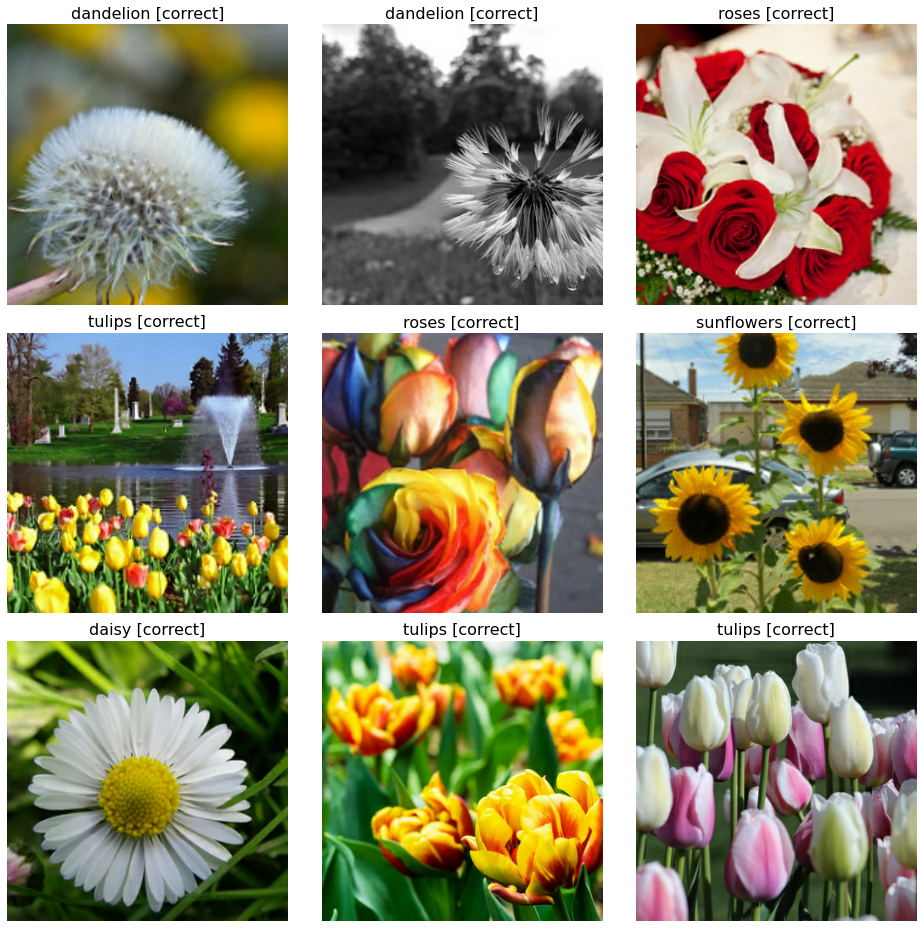

In [ ]:
# Re-run this cell to show a new batch of images
images, classes = next(validation_viz_iterator)
titles, colors = get_titles(images, classes, model)
display_nine_flowers(images, titles, colors)

## Save and re-loading our trained model

In [ ]:
# We can save our model with:
model.save('model.h5')
# and reload it with:
reloaded_model = tf.keras.models.load_model('model.h5')

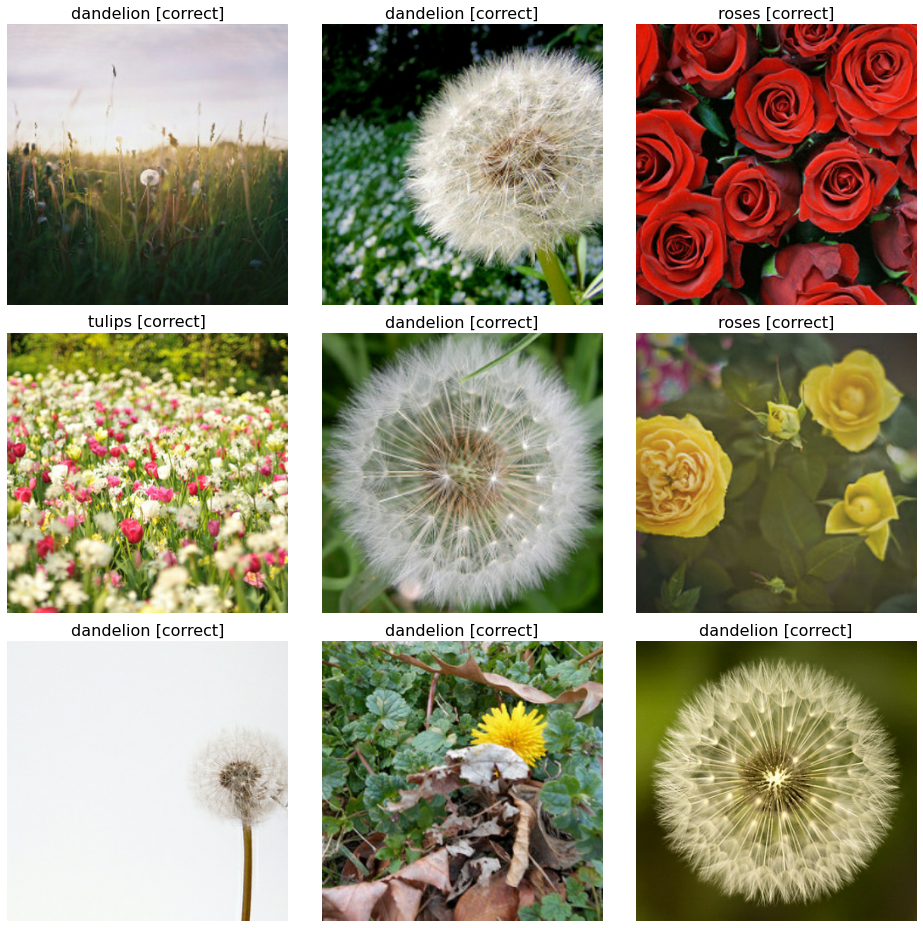

In [ ]:
# Re-run this cell to show a new batch of images
images, classes = next(validation_viz_iterator)
titles, colors = get_titles(images, classes, reloaded_model)
display_nine_flowers(images, titles, colors)

## Next steps

More TPU/Keras examples include:
- [Shakespeare in 5 minutes with Cloud TPUs and Keras](https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/shakespeare_with_tpu_and_keras.ipynb)
- [Fashion MNIST with Keras and TPUs](https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/fashion_mnist.ipynb)

We'll be sharing more examples of TPU use in Colab over time, so be sure to check back for additional example links, or [follow us on Twitter @GoogleColab](https://twitter.com/googlecolab).